In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

# for creating validation set
from sklearn.model_selection import train_test_split

# for establishing a baseline
from sklearn.dummy import DummyClassifier

# for evaluating the model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# for dimensionality reduction
from sklearn.decomposition import PCA

# for the classification - we chose a RandomForest model
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import csr_matrix

# for ROC curve plots
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [2]:
features = pd.read_csv('features_filtered.csv', encoding='latin')
features.head()

id          gen            sp  ssp             en            cnt  \
0  564895  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
1  545775  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
2  540857  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
3  540855  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
4  487506  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   

                                                 loc  \
0  Lyons Township (near  Willow Springs), Cook Co...   
1  Valley Forge National Historical Park, Montgom...   
2  Slaterville Rd @ Honness (near  Ithaca), Tompk...   
3  Slaterville Rd @ Honness (near  Ithaca), Tompk...   
4  Lake Artemesia Natural Area, Prince George's C...   

                         type         q length bird-seen  \
0  adult, sex uncertain, song  no score   0:16        no   
1                        call  no score   0:17       yes   
2                        song  no score   0:32   unknown   
3                        song  no score   0:52   unknown   
4                        song  no score   0:25       yes   

                                   file category  
0  //www.xeno-canto.org/564895/download     song  
1  //www.xeno-canto.org/545775/download     call  
2  //www.xeno-canto.org/540857/download     song  
3  //www.xeno-canto.org/540855/download     song  
4  //www.xeno-canto.org/487506/download     song

In [47]:
features.length = features.apply(lambda row: int(row.length.split(':')[0])*60+int(row.length.split(':')[1]), axis=1)
features.head()

id          gen            sp  ssp             en            cnt  \
0  564895  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
1  545775  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
2  540857  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
3  540855  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   
4  487506  Thryothorus  ludovicianus  NaN  Carolina Wren  United States   

                                                 loc  \
0  Lyons Township (near  Willow Springs), Cook Co...   
1  Valley Forge National Historical Park, Montgom...   
2  Slaterville Rd @ Honness (near  Ithaca), Tompk...   
3  Slaterville Rd @ Honness (near  Ithaca), Tompk...   
4  Lake Artemesia Natural Area, Prince George's C...   

                         type         q  length bird-seen  \
0  adult, sex uncertain, song  no score      16        no   
1                        call  no score      17       yes   
2                        song  no score      32   unknown   
3                        song  no score      52   unknown   
4                        song  no score      25       yes   

                                   file category  
0  //www.xeno-canto.org/564895/download     song  
1  //www.xeno-canto.org/545775/download     call  
2  //www.xeno-canto.org/540857/download     song  
3  //www.xeno-canto.org/540855/download     song  
4  //www.xeno-canto.org/487506/download     song

Text(0, 0.5, 'Count')

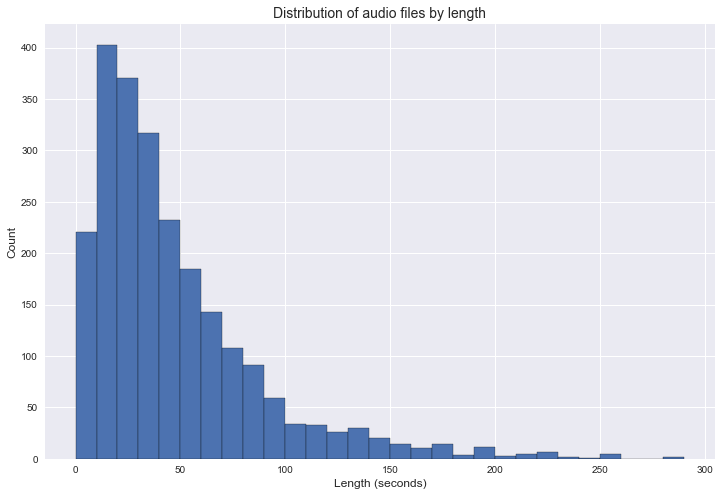

In [75]:
import seaborn as sns
bins_list = [elem for elem in range(0, 300, 10)]
plt.figure(figsize=(12, 8))
features.length.hist(bins = bins_list, edgecolor='black')
plt.title('Distribution of audio files by length', fontsize=14)
plt.xlabel('Length (seconds)', fontsize=12)
plt.ylabel('Count', fontsize=12)

In [3]:
# These are the top species we selected for our analysis
selected_species = ['Red-winged Blackbird', 
                    'Common Yellowthroat', 
                    'Northern Cardinal', 
                    'Carolina Wren', 
                    'Red Crossbill', 
                    'Spotted Towhee']
# We only need the id and the labels for our CNN.
dataset = features[features.en.isin(selected_species)][['id', 'en', 'category']]
# Now we need to change our labels into integers as torch does not support string format for labels.
specie_labels = {"Red-winged Blackbird": 0, 'Common Yellowthroat': 1, 'Northern Cardinal': 2, 'Carolina Wren': 3,
          'Red Crossbill': 4, 'Spotted Towhee': 5}
category_labels = {"song": 0, "call": 1}
dataset['label'] = dataset.apply(lambda row: [specie_labels[row.en], category_labels[row.category]], axis=1)
dataset.drop(['en', 'category'], axis=1, inplace=True)

In [4]:
dataset.head()

id   label
0  564895  [3, 0]
1  545775  [3, 1]
2  540857  [3, 0]
3  540855  [3, 0]
4  487506  [3, 0]

In [5]:
def load_images(dataset, path='mel_spectrograms_8sec', gray=True):
    img_df = []
    for img_name in tqdm(dataset['id']):
        # defining the image path
        image_path = f'images/{path}/' + str(img_name) + '.jpg'
        # reading the image
        img = imread(image_path)
        # appending the image into the list
        img_df.append(img.flatten())
    
    # converting the list to numpy array
    return np.array(img_df)


def visualizing_images(dataset):
    # Only works for 2D arrays
    i = 0
    plt.figure(figsize=(10,10))
    plt.subplot(221), plt.imshow(dataset[i], cmap='gray')
    plt.subplot(222), plt.imshow(dataset[i+25], cmap='gray')
    plt.subplot(223), plt.imshow(dataset[i+50], cmap='gray')
    plt.subplot(224), plt.imshow(dataset[i+75], cmap='gray')

In [10]:
X, y = load_images(dataset), np.array(list(dataset['label']))
X.shape, y.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2371/2371 [00:02<00:00, 1057.75it/s]


((2371, 132480), (2371, 2))

In [71]:
y

array([[3, 0],
       [3, 1],
       [3, 0],
       ...,
       [2, 0],
       [2, 0],
       [2, 0]])

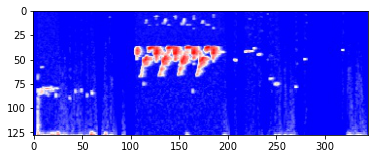

In [50]:
img = X[0].reshape(128, 345, 3)
plt.imshow(img, cmap='bwr')

# Dummy Classifier
To establish our baseline, we want to train a dummy classifier on the most common class in our dataset. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print('')
print(X_test.shape)

In [79]:
dummry_clf = MultiOutputClassifier(DummyClassifier(strategy="most_frequent")).fit(X_train, y_train)
y_pred = dummry_clf.predict(X_test)

In [97]:
# Since metrics do not handle multiouput labels, we need to convert them to single digits.
y_test_metric = y_test.reshape(1, y_test.shape[0]*y_test.shape[1])[0] # better than np.argmax()?
y_pred_metric = y_pred.reshape(1, y_pred.shape[0]*y_pred.shape[1])[0]
print("Accuracy:", accuracy_score(y_test_metric, y_pred.reshape(1, y_pred.shape[0]*y_pred.shape[1])[0]))
print("f1 score:", f1_score(y_test_metric, y_pred_metric, average='micro'))

Accuracy: 0.3778947368421053
f1 score: 0.3778947368421053


# PCA - Dimensionality Reduction

In [24]:
def pca_reduction(parameter):
    '''Parameter should be percentage variance retained (e.g. 0.95) or number of components (e.g. 2)''' 
    pca_model = PCA(parameter)
    X_proj = pca_model.fit_transform(X)
    return pca_model, X_proj

def inv_transform(pca_model, reduced_X):
    '''Reconstructs the images using the reduced dataset using inverse transform to convert images back to their
    original dimension. Note that we are not reverting back to the original data, we're going back to the actual dimension
    of the original images so that we can visualize them. 
    ''' 
    X_inv_proj = pca_model.inverse_transform(reduced_X) 
    #reshaping as 2371 images of 128*1035 dimension 
    X_proj_img = np.reshape(X_inv_proj,(2371 , 128, 1035))
    return X_proj_img

def images_plot(images, n_dim, cmap):
    '''Dimensions are of shape (128*345*3) or (128*1035)'''
    if n_dim == 3:
        fig, axes = plt.subplots(5, 4, figsize=(15, 8),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i].reshape(128, 345, 3), cmap=cmap)
    elif n_dim == 2:
        fig, axes = plt.subplots(5, 2, figsize=(20, 8),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i].reshape(128, 1035), cmap=cmap)
    else:
        print('not enough or too many dimensions')

In [99]:
pca_model, X_proj = pca_reduction(0.98)
X_proj.shape

(2371, 1798)

In [102]:
X_proj_img = inv_transform(pca_model, X_proj
X_proj_img.shape

(2371, 128, 1035)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

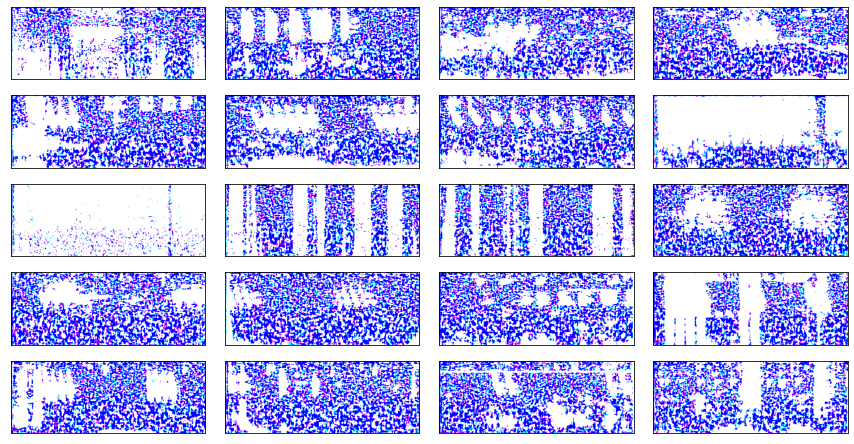

In [103]:
# Showing the pca-reduced images
images_plot(X_proj_img, 3, 'bwr')

In [104]:
inv_img = pca_model.inverse_transform(X_proj)

# Random Forest 

In [105]:
# # Taking 20% of the dataset off for testing

X_train, X_test, y_train, y_test = train_test_split(inv_img, y, test_size=0.20, random_state=42)

print(X_train.shape)
print('')
print(X_test.shape)

(1896, 132480)

(475, 132480)


In [106]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 319]
 [  1 276]
 [  2  88]
 [  3  79]
 [  4  88]
 [  5 100]]


In [109]:
#Create a Random Forest Classifier
clf=MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [110]:
# Model Accuracy, how often is the classifier correct?
y_test_metric = y_test.reshape(1, y_test.shape[0]*y_test.shape[1])[0] # better than np.argmax()?
y_pred_metric = y_pred.reshape(1, y_pred.shape[0]*y_pred.shape[1])[0]
print("Accuracy:", accuracy_score(y_test_metric, y_pred_metric))
print("f1 score:", f1_score(y_test_metric, y_pred_metric, average='micro'))
print("F1 score: ", f1_score(y_test_metric, y_pred_metric, average='weighted'))

Accuracy: 0.5589473684210526
f1 score: 0.5589473684210526
F1 score:  0.5574273197152082


In [113]:
y_test_metric = y_test.reshape(1, y_test.shape[0]*y_test.shape[1])[0] # better than np.argmax()?
y_pred_metric = y_pred.reshape(1, y_pred.shape[0]*y_pred.shape[1])[0]
print("Accuracy:", accuracy_score(y_test_metric, y_pred_metric))
print("f1 score:", f1_score(y_test_metric, y_pred_metric, average='micro'))
print("F1 score: ", f1_score(y_test_metric, y_pred_metric, average='weighted'))
bird_pred = [elem[0] for elem in y_pred]
song_pred = [elem[1] for elem in y_pred]
bird_test = [elem[0] for elem in y_test]
song_test = [elem[1] for elem in y_test]
print("Accuracy on specie:", accuracy_score(bird_test, bird_pred))
print("F1 score on specie (micro):", f1_score(bird_test, bird_pred, average='micro'))
print("F1 score on specie (weighted): ", f1_score(bird_test, bird_pred, average='weighted'))
print("Accuracy on song:", accuracy_score(song_test, song_pred))
print("F1 score on song (micro):", f1_score(song_test, song_pred, average='micro'))
print("F1 score on song (weighted): ", f1_score(song_test, song_pred, average='weighted'))

Accuracy on specie: 0.4694736842105263
F1 score on specie (micro): 0.46947368421052627
F1 score on specie (weighted):  0.4562815648622798
Accuracy on song: 0.6484210526315789
F1 score on song (micro): 0.6484210526315789
F1 score on song (weighted):  0.6440491561461125


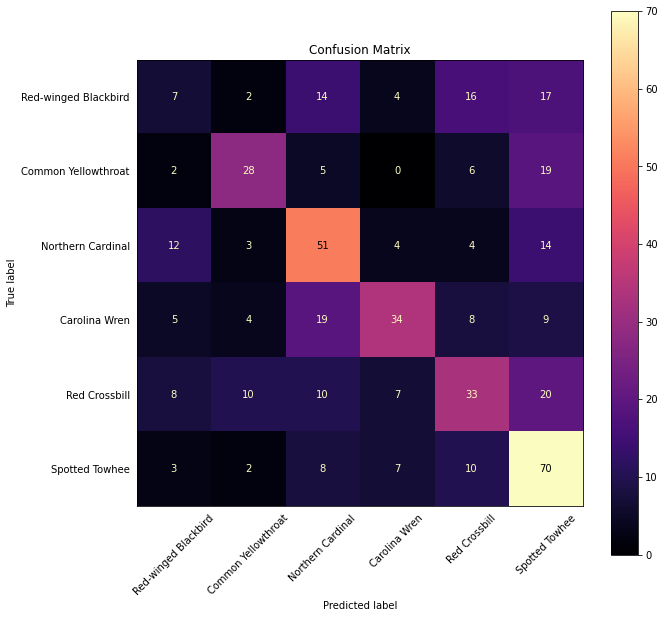

In [114]:
cm = confusion_matrix(bird_test, bird_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=selected_species)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')

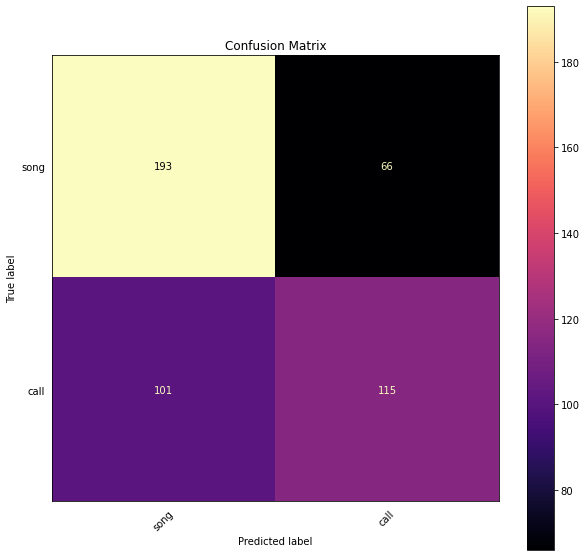

In [115]:
cm = confusion_matrix(song_test, song_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['song', 'call'])
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')

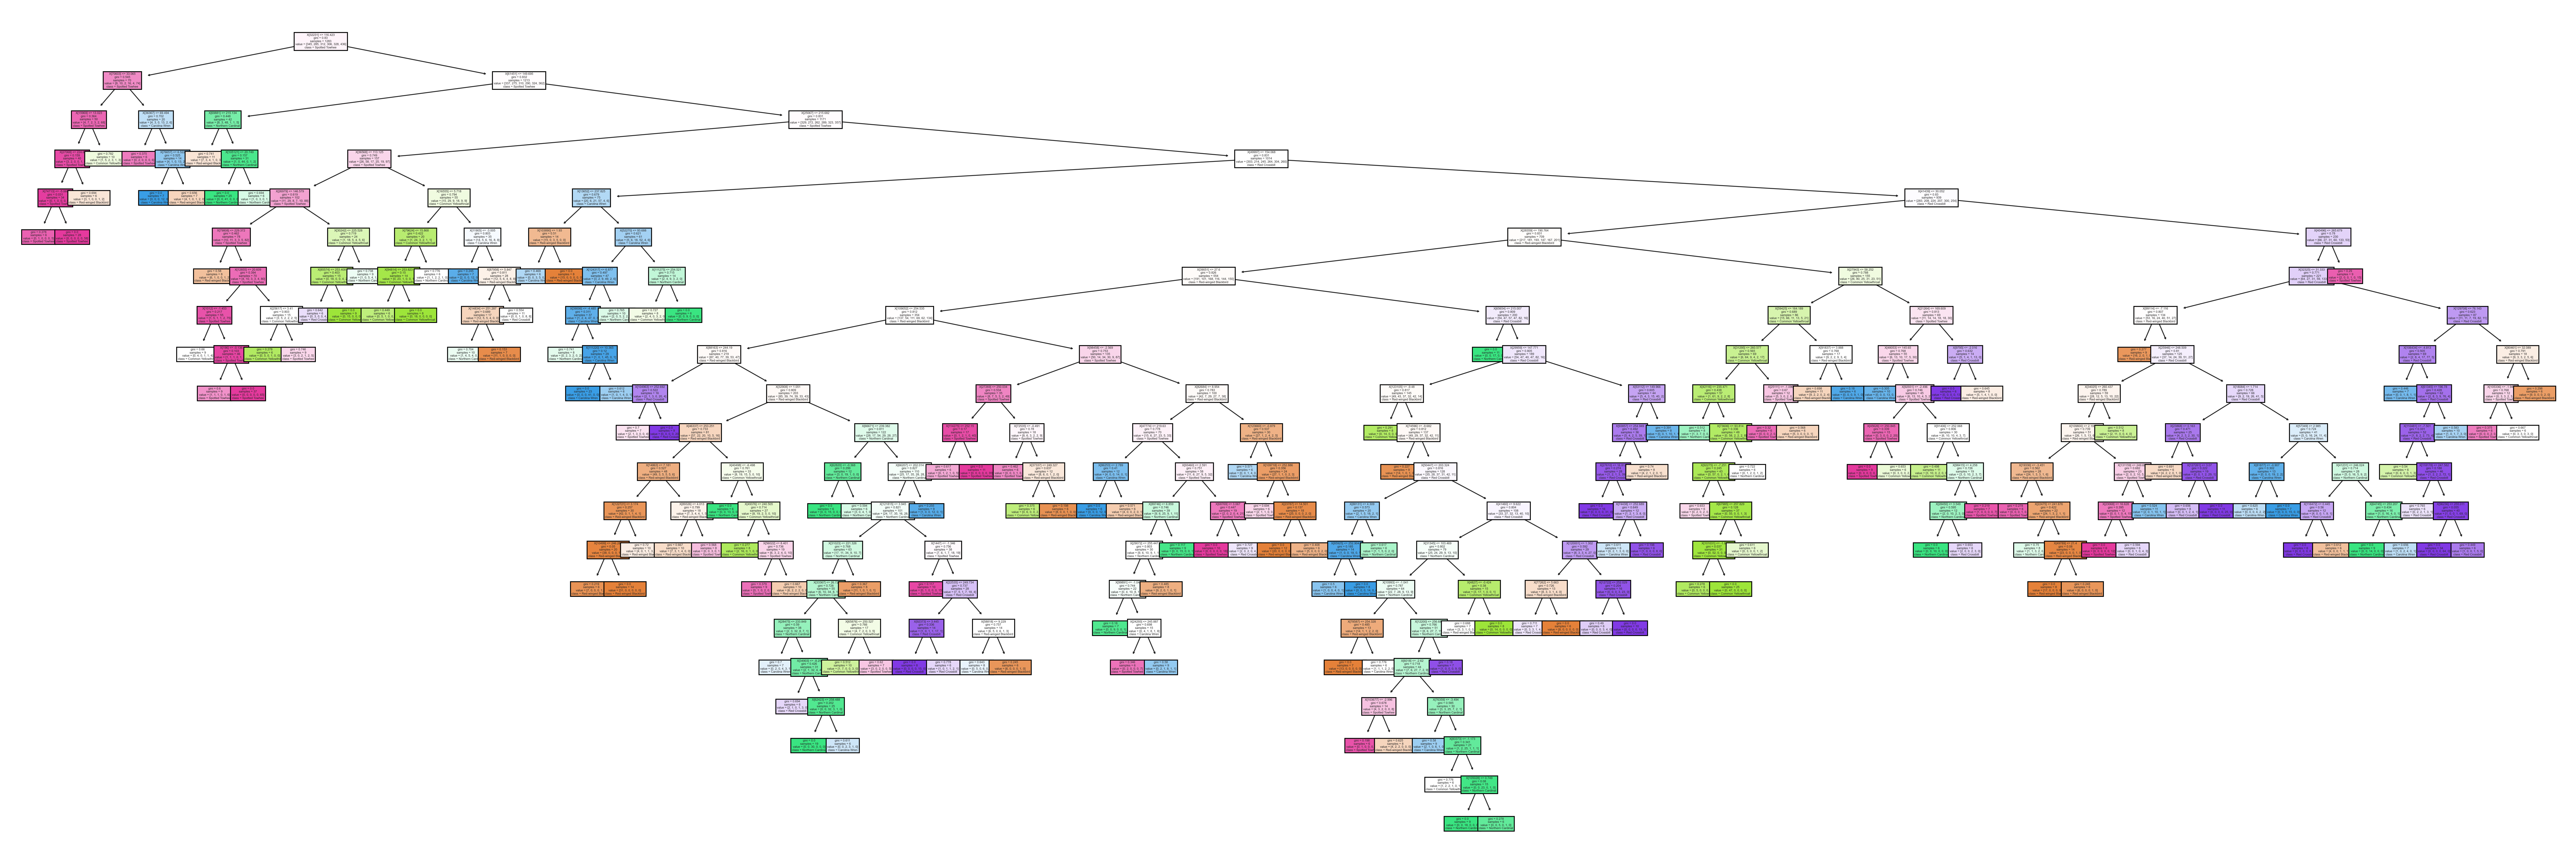

In [115]:
from sklearn.tree import plot_tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5), dpi=800)
plot_tree(clf.estimators_[99],
               class_names=selected_species,
               filled = True);
fig.savefig('rf_denoised_pca_reduced_imges.png')

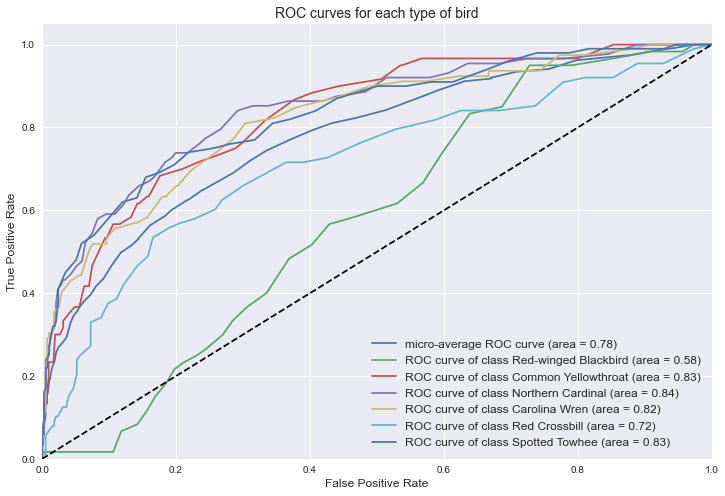

In [120]:
# Get the multiclass ROC
# Binarize the output
y_bin = label_binarize([elem[0] for elem in y], classes=[0, 1, 2, 3, 4, 5])
n_classes = y_bin.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=.20,
                                                    random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, 
                                                        random_state=42))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curves
plt.figure(figsize=(12, 8))
plt.style.use('seaborn')
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(selected_species[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curves for each type of bird', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Spherical K-Means

In [214]:
with open('spherical_kmeans_features.npy', 'rb') as f:
    X_skm = np.load(f, allow_pickle=False)

In [215]:
X_skm.shape

(2516, 150)

In [216]:
# # Taking 20% of the dataset off for testing
X_train, X_test, y_train, y_test = train_test_split(X_skm, y, test_size=0.20, random_state=42)

print(X_train.shape)
print('')
print(X_test.shape)

(2012, 150)

(504, 150)


In [217]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [218]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.40476190476190477


In [219]:
print("F1 score: ", f1_score(y_test, y_pred, average='micro'))
print("F1 score: ", f1_score(y_test, y_pred, average='weighted'))

F1 score:  0.40476190476190477
F1 score:  0.4050672908610381
F1 score:  0.4043708983265926


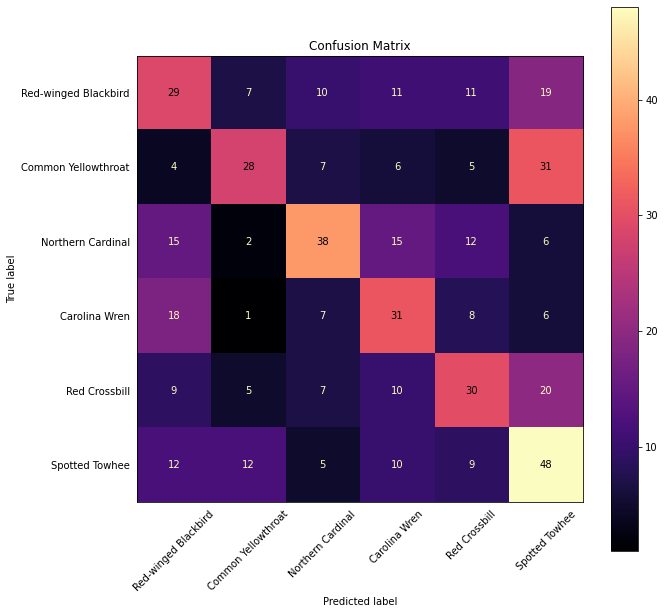

In [198]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=selected_species)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')

In [199]:
from sklearn.metrics import roc_auc_score

In [221]:
roc_auc_score(y, clf.predict_proba(X_skm), multi_class='ovr')

0.9837350603676884

# Random Forest on Original Images

In [129]:
X, y = load_images(dataset, path='mel_spectrograms_8sec_unprocessed', gray=True), np.array(list(dataset['label']))
X.shape, y.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2371/2371 [00:02<00:00, 845.60it/s]


((2371, 132480), (2371, 2))

In [130]:
# # Taking 20% of the dataset off for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print('')
print(X_test.shape)

#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=6)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

(1896, 132480)

(475, 132480)


In [131]:
y_test_metric = y_test.reshape(1, y_test.shape[0]*y_test.shape[1])[0] # better than np.argmax()?
y_pred_metric = y_pred.reshape(1, y_pred.shape[0]*y_pred.shape[1])[0]
print("Accuracy:", accuracy_score(y_test_metric, y_pred_metric))
print("f1 score:", f1_score(y_test_metric, y_pred_metric, average='micro'))
print("F1 score: ", f1_score(y_test_metric, y_pred_metric, average='weighted'))
bird_pred = [elem[0] for elem in y_pred]
song_pred = [elem[1] for elem in y_pred]
bird_test = [elem[0] for elem in y_test]
song_test = [elem[1] for elem in y_test]
print("Accuracy on specie:", accuracy_score(bird_test, bird_pred))
print("F1 score on specie (micro):", f1_score(bird_test, bird_pred, average='micro'))
print("F1 score on specie (weighted): ", f1_score(bird_test, bird_pred, average='weighted'))
print("Accuracy on song:", accuracy_score(song_test, song_pred))
print("F1 score on song (micro):", f1_score(song_test, song_pred, average='micro'))
print("F1 score on song (weighted): ", f1_score(song_test, song_pred, average='weighted'))

Accuracy: 0.5378947368421053
f1 score: 0.5378947368421053
F1 score:  0.5365891171100439
Accuracy on specie: 0.42105263157894735
F1 score on specie (micro): 0.42105263157894735
F1 score on specie (weighted):  0.40826024038451875
Accuracy on song: 0.6547368421052632
F1 score on song (micro): 0.6547368421052632
F1 score on song (weighted):  0.6506225252885327


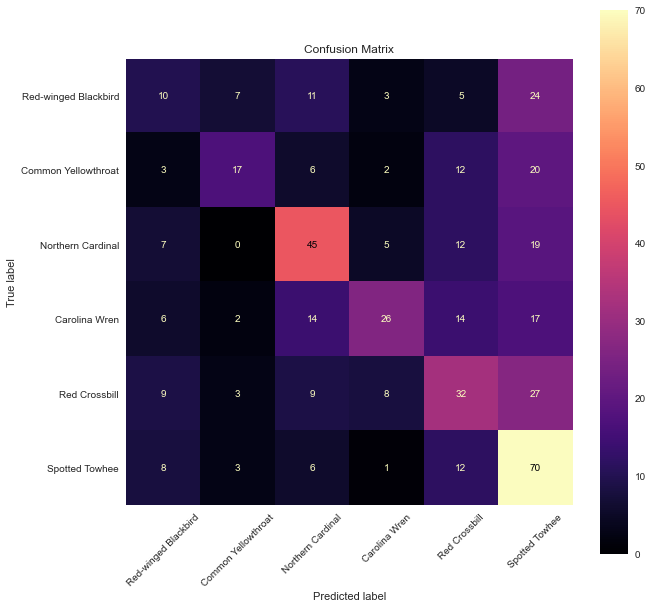

In [136]:
cm = confusion_matrix(bird_test, bird_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=selected_species)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.grid(False)
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')

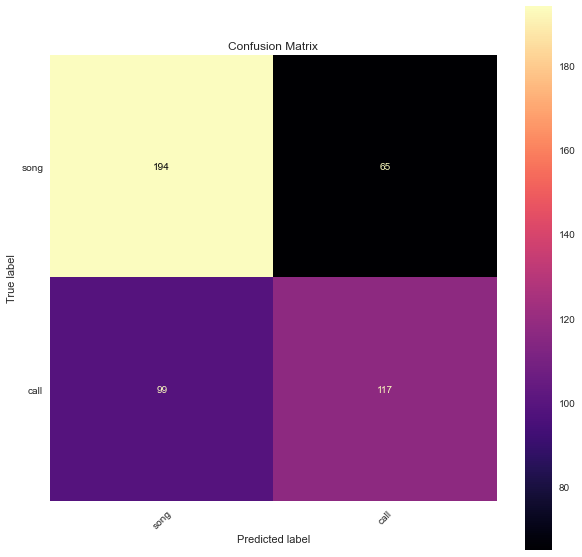

In [137]:
cm = confusion_matrix(song_test, song_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['song', 'call'])
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.grid(False)
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')

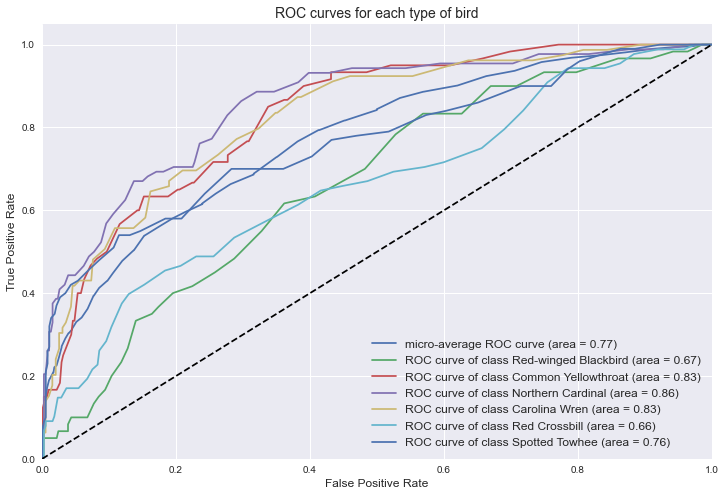

In [135]:
# Get the multiclass ROC
# Binarize the output
y_bin = label_binarize([elem[0] for elem in y], classes=[0, 1, 2, 3, 4, 5])
n_classes = y_bin.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=.20,
                                                    random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, 
                                                        random_state=42))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curves
plt.figure(figsize=(12, 8))
plt.style.use('seaborn')
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(selected_species[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curves for each type of bird', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.show()

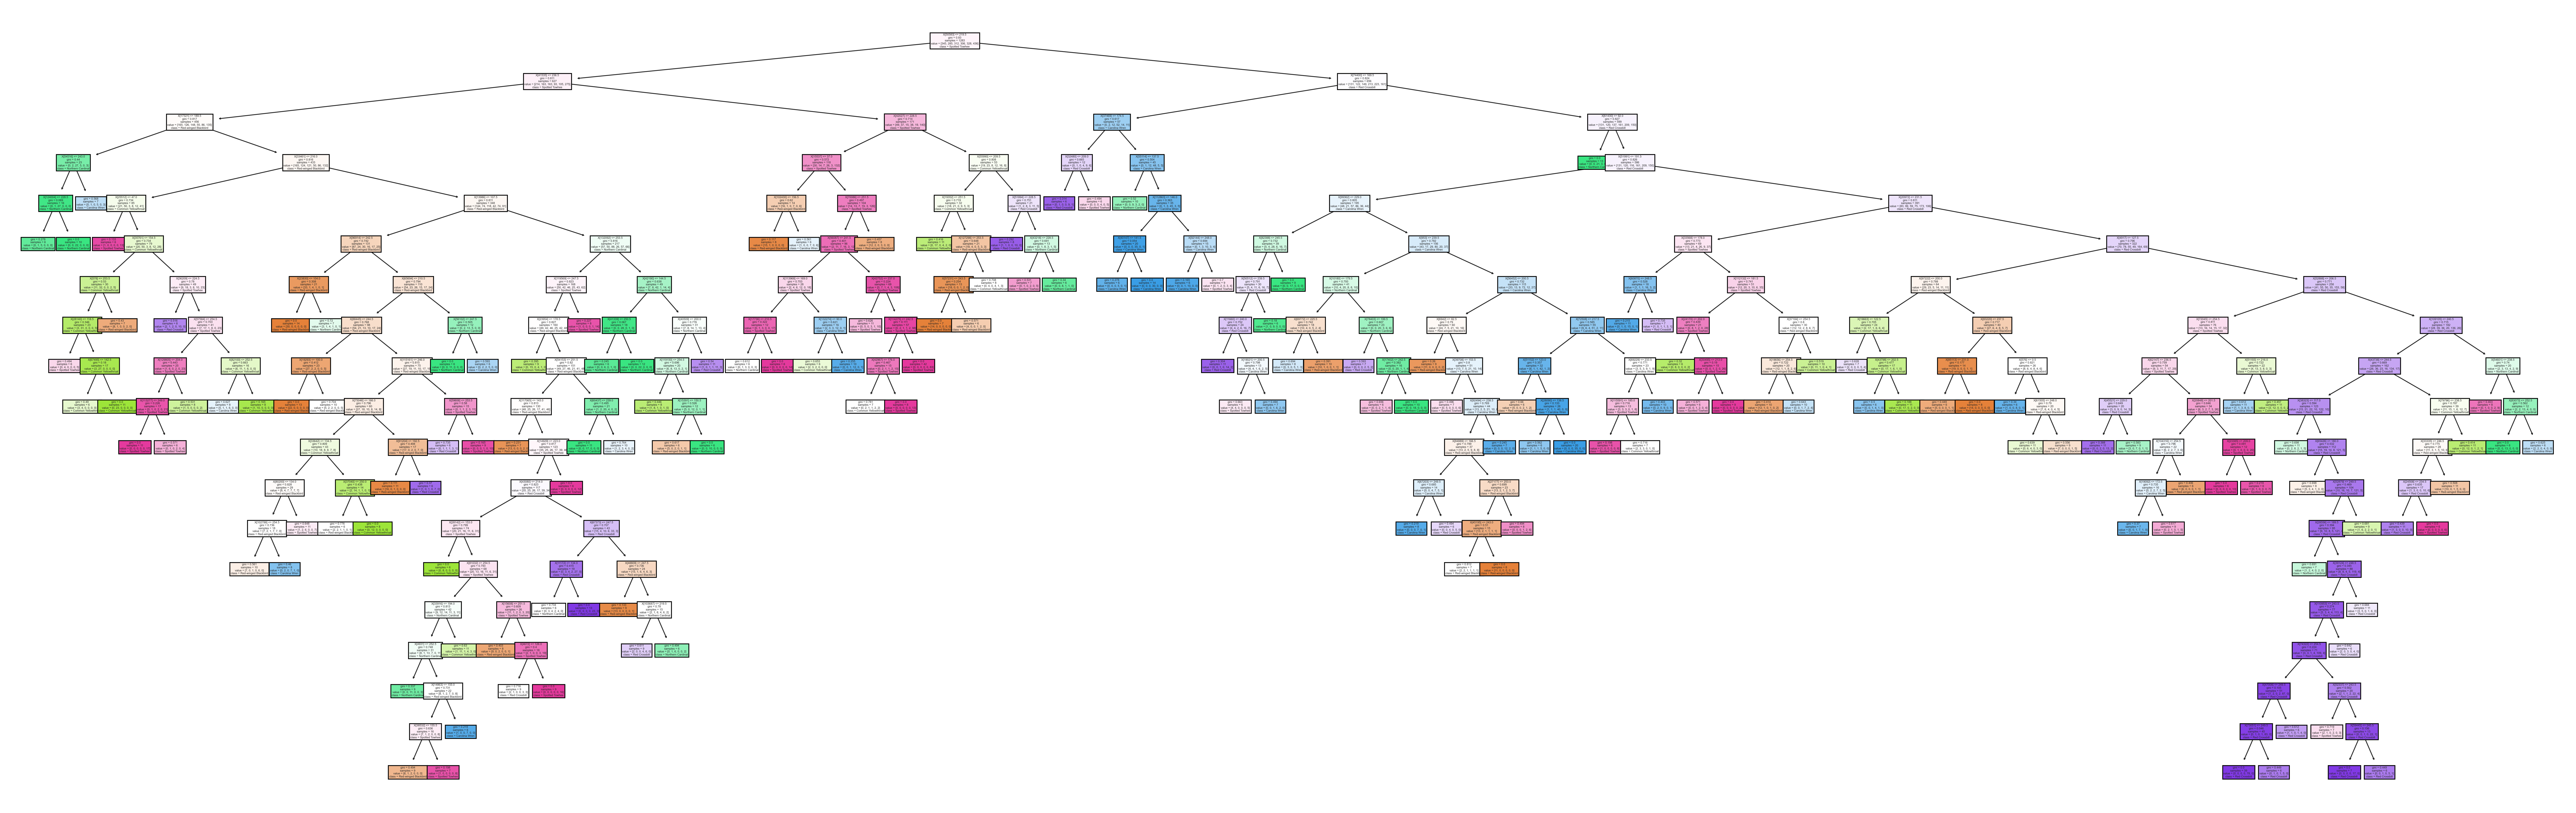

In [97]:
from sklearn.tree import plot_tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (16,5), dpi=800)
plot_tree(clf.estimators_[99],
               class_names=selected_species,
               filled = True);
fig.savefig('rf_original_imges.png')

# Random Forest on 2 seconds images with silence

In [148]:
X, y = load_images(dataset, path='mel_spectrograms_2sec_no_silence', gray=True), np.array(list(dataset['label']))
X.shape, y.shape

100%|████████████████████████████████████████████████████████████████████████████| 2371/2371 [00:01<00:00, 1659.75it/s]


((2371, 33408), (2371, 2))

In [149]:
# # Taking 20% of the dataset off for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print('')
print(X_test.shape)

#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=6)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

(1896, 33408)

(475, 33408)


In [150]:
y_test_metric = y_test.reshape(1, y_test.shape[0]*y_test.shape[1])[0] # better than np.argmax()?
y_pred_metric = y_pred.reshape(1, y_pred.shape[0]*y_pred.shape[1])[0]
print("Accuracy:", accuracy_score(y_test_metric, y_pred_metric))
print("f1 score:", f1_score(y_test_metric, y_pred_metric, average='micro'))
print("F1 score: ", f1_score(y_test_metric, y_pred_metric, average='weighted'))
bird_pred = [elem[0] for elem in y_pred]
song_pred = [elem[1] for elem in y_pred]
bird_test = [elem[0] for elem in y_test]
song_test = [elem[1] for elem in y_test]
print("Accuracy on specie:", accuracy_score(bird_test, bird_pred))
print("F1 score on specie (micro):", f1_score(bird_test, bird_pred, average='micro'))
print("F1 score on specie (weighted): ", f1_score(bird_test, bird_pred, average='weighted'))
print("Accuracy on song:", accuracy_score(song_test, song_pred))
print("F1 score on song (micro):", f1_score(song_test, song_pred, average='micro'))
print("F1 score on song (weighted): ", f1_score(song_test, song_pred, average='weighted'))

Accuracy: 0.6305263157894737
f1 score: 0.6305263157894737
F1 score:  0.6324667826080297
Accuracy on specie: 0.5305263157894737
F1 score on specie (micro): 0.5305263157894737
F1 score on specie (weighted):  0.5240624402646327
Accuracy on song: 0.7305263157894737
F1 score on song (micro): 0.7305263157894737
F1 score on song (weighted):  0.728337476551419


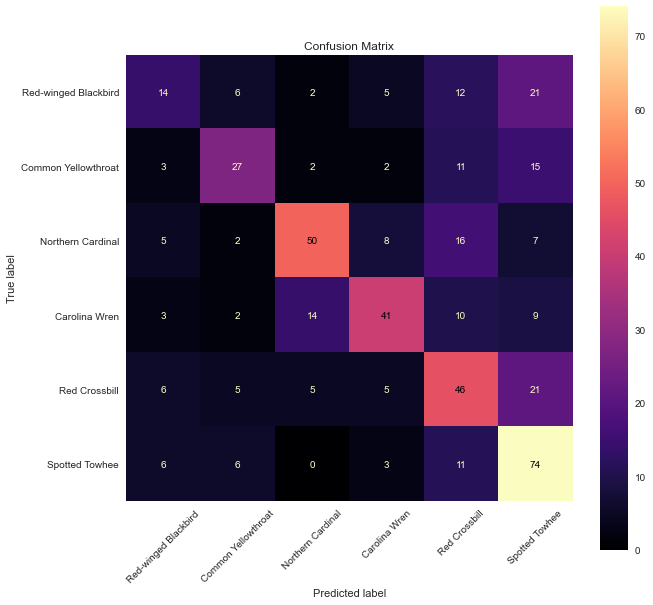

In [151]:
cm = confusion_matrix(bird_test, bird_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=selected_species)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.grid(False)
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')

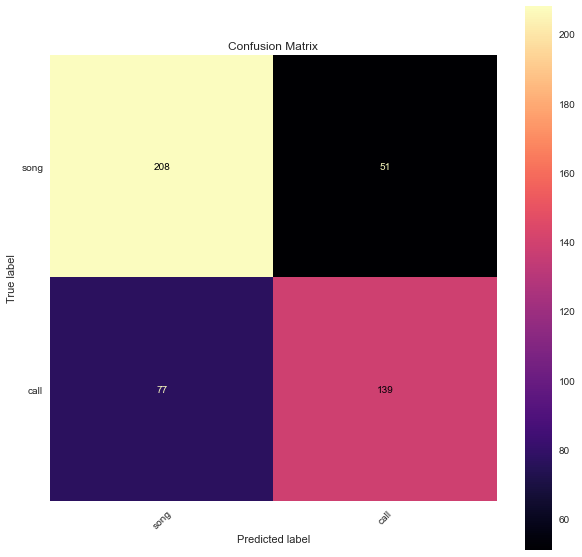

In [152]:
cm = confusion_matrix(song_test, song_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['song', 'call'])
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.grid(False)
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')

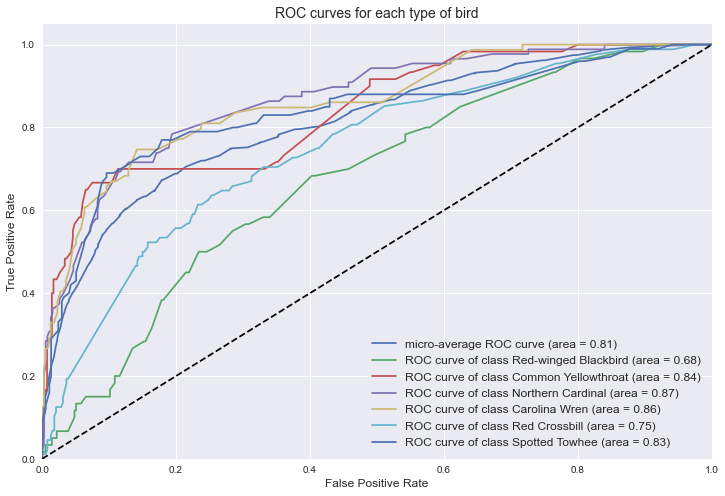

In [153]:
# Get the multiclass ROC
# Binarize the output
y_bin = label_binarize([elem[0] for elem in y], classes=[0, 1, 2, 3, 4, 5])
n_classes = y_bin.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=.20,
                                                    random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, 
                                                        random_state=42))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curves
plt.figure(figsize=(12, 8))
plt.style.use('seaborn')
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(selected_species[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curves for each type of bird', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Random Forest on best clips images

In [33]:
X, y = load_images(dataset, path='mel_spectrograms_best_clip', gray=True), np.array(list(dataset['label']))
X.shape, y.shape

100%|████████████████████████████████████████████████████████████████████████████| 2371/2371 [00:01<00:00, 1875.74it/s]


((2371, 24960), (2371, 2))

In [34]:
# # Taking 20% of the dataset off for testing
X_train, X_test, y_train, y_test = train_test_split(inv_img, y, test_size=0.20, random_state=42)

print(X_train.shape)
print('')
print(X_test.shape)

#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=6)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

(1896, 24960)

(475, 24960)


In [35]:
y_test_metric = y_test.reshape(1, y_test.shape[0]*y_test.shape[1])[0] # better than np.argmax()?
y_pred_metric = y_pred.reshape(1, y_pred.shape[0]*y_pred.shape[1])[0]
print("Accuracy:", accuracy_score(y_test_metric, y_pred_metric))
print("f1 score:", f1_score(y_test_metric, y_pred_metric, average='micro'))
print("F1 score: ", f1_score(y_test_metric, y_pred_metric, average='weighted'))
bird_pred = [elem[0] for elem in y_pred]
song_pred = [elem[1] for elem in y_pred]
bird_test = [elem[0] for elem in y_test]
song_test = [elem[1] for elem in y_test]
print("Accuracy on specie:", accuracy_score(bird_test, bird_pred))
print("F1 score on specie (micro):", f1_score(bird_test, bird_pred, average='micro'))
print("F1 score on specie (weighted): ", f1_score(bird_test, bird_pred, average='weighted'))
print("Accuracy on song:", accuracy_score(song_test, song_pred))
print("F1 score on song (micro):", f1_score(song_test, song_pred, average='micro'))
print("F1 score on song (weighted): ", f1_score(song_test, song_pred, average='weighted'))

Accuracy: 0.6421052631578947
f1 score: 0.6421052631578947
F1 score:  0.6383999888583272
Accuracy on specie: 0.5136842105263157
F1 score on specie (micro): 0.5136842105263157
F1 score on specie (weighted):  0.5012734545890465
Accuracy on song: 0.7705263157894737
F1 score on song (micro): 0.7705263157894737
F1 score on song (weighted):  0.7671738558093675


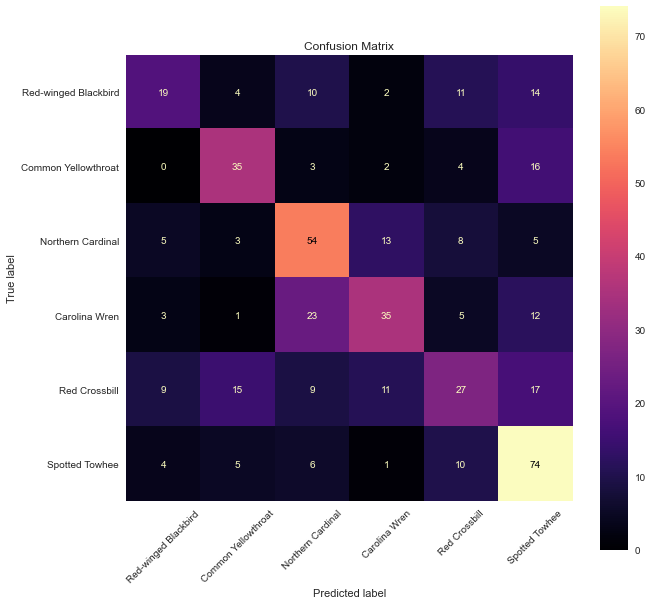

In [36]:
cm = confusion_matrix(bird_test, bird_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=selected_species)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.grid(False)
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')

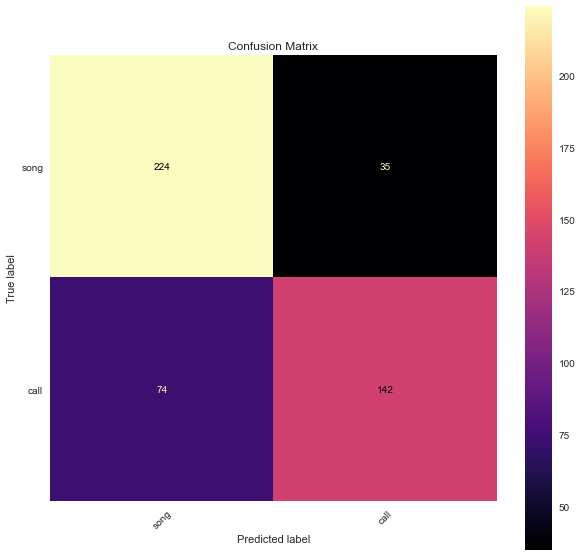

In [37]:
cm = confusion_matrix(song_test, song_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['song', 'call'])
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Predicted labels')
ax.tick_params(axis = "both", which = "both", bottom = False, left=False)
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.grid(False)
disp.plot(ax=ax, xticks_rotation=45, cmap='magma')

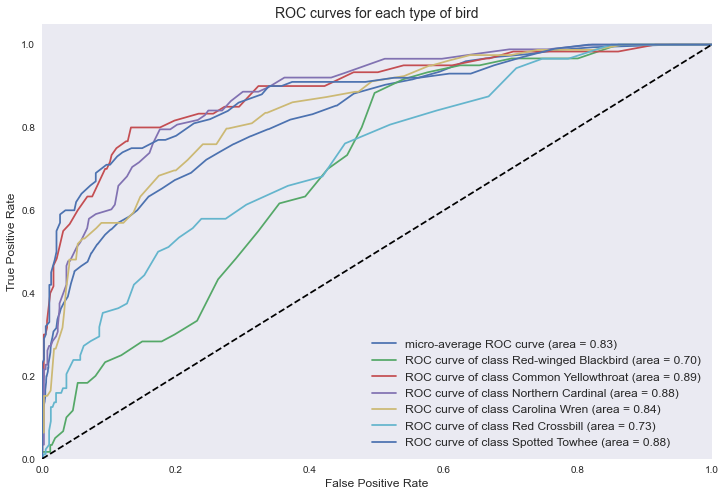

In [38]:
# Get the multiclass ROC
# Binarize the output
y_bin = label_binarize([elem[0] for elem in y], classes=[0, 1, 2, 3, 4, 5])
n_classes = y_bin.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=.20,
                                                    random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, 
                                                        random_state=42))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curves
plt.figure(figsize=(12, 8))
plt.style.use('seaborn')
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(selected_species[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curves for each type of bird', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(False)
plt.show()

# To do
1. Try the RF with best clips 1, 1.5sec, 4-5sec.
2. Run 2 CNNs: one for song, one for call - on different lengths (8sec, best clips)

Nice to have? (Data Augmentation - Next steps)
3. Try trimming on silence, try multiple best clips and create folders with each label combination. 

Nice to have:
- visualize the spherical k-means if we can - maybe use UMAP to reduce to 2D
- Create validation dataset on (all?) models
- test CNN on PCA reduced images - likely not super useful as CNN already reduces dimensionality
- add cross-validation

#### 2 seconds
- Accuracy: 0.6442105263157895
- f1 score: 0.6442105263157895
- F1 score:  0.6400132424186927
- Accuracy on specie: 0.5305263157894737
- F1 score on specie (micro): 0.5305263157894737
- F1 score on specie (weighted):  0.5173630929415608
- Accuracy on song: 0.7578947368421053
- F1 score on song (micro): 0.7578947368421053
- F1 score on song (weighted):  0.7531867480446894

#### 1.5 seconds
- Accuracy: 0.6621052631578948
- f1 score: 0.6621052631578948
- F1 score:  0.6578911690583301
- Accuracy on specie: 0.5663157894736842
- F1 score on specie (micro): 0.5663157894736842
- F1 score on specie (weighted):  0.5590512567465477
- Accuracy on song: 0.7578947368421053
- F1 score on song (micro): 0.7578947368421053
- F1 score on song (weighted):  0.753792141572192

#### 1 second
- Accuracy: 0.6610526315789473
- f1 score: 0.6610526315789473
- F1 score:  0.6597201013637579
- Accuracy on specie: 0.5515789473684211
- F1 score on specie (micro): 0.5515789473684211
- F1 score on specie (weighted):  0.5427170354674525
- Accuracy on song: 0.7705263157894737
- F1 score on song (micro): 0.7705263157894737
- F1 score on song (weighted):  0.7669104902679174

#### 4 seconds
- Accuracy: 0.6410526315789473
- f1 score: 0.6410526315789473
- F1 score:  0.6419304465287142
- Accuracy on specie: 0.5452631578947369
- F1 score on specie (micro): 0.5452631578947369
- F1 score on specie (weighted):  0.5350764087959701
- Accuracy on song: 0.7368421052631579
- F1 score on song (micro): 0.7368421052631579
- F1 score on song (weighted):  0.7352455458486961